In [1]:
import os
import sys
import glob
import pickle
import numpy as np
import pandas as pd
import catboost
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt
from itertools import combinations
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics.cluster import adjusted_rand_score

In [203]:
df_coreMLST = pd.read_csv(
    "../../Data/10359_coreMLST_dataframe.txt",sep='\t')

<ipython-input-203-6d77e7070be9>:1: DtypeWarning: Columns (4,158,182,204,341,376,454,671,728,749,750,782,871,901,948,1111,1163,1289) have mixed types. Specify dtype option on import or set low_memory=False.
  df_coreMLST = pd.read_csv(


In [204]:
df_coreMLST.head()

,id,CAMP0001,CAMP0002,CAMP0003,CAMP0006,CAMP0007,CAMP0009,CAMP0010,CAMP0012,CAMP0013,...,CAMP1846,CAMP1847,CAMP1848,CAMP1849,CAMP1850,CAMP1851,CAMP1852,CAMP1853,CAMP1854,cgST (C. jejuni / C. coli cgMLST v1.0)
0,2659,1,37.0,40.0,14.0,174.0,25.0,1.0,30.0,1.0,...,1,1.0,1,1,1,1,17,2,1,26
1,2663,152,27.0,666.0,71.0,177.0,36.0,28.0,31.0,351.0,...,1,1.0,1,1,1,2,17,5,2,28
2,2670,142,94.0,111.0,14.0,117.0,48.0,35.0,2.0,1.0,...,1,1.0,1,1,1,1,1,1,1,32
3,2672,31,58.0,61.0,35.0,67.0,37.0,29.0,42.0,37.0,...,1,1.0,1,1,3,1,17,2,2,34
4,5858,1,30.0,29.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1,1.0,1,1,1,1,17,1,2,58


In [205]:
df_MLST_Meta = pd.read_excel(
    "../../Data/10359_Dataframe_metadata.xlsx")

In [206]:
df_MLST_Meta.head()

,id,isolate,aliases,country,continent,region,year,month,isolation_date,received_date,...,datestamp,aspA,glnA,gltA,glyA,pgm,tkt,uncA,ST (MLST),clonal_complex (MLST)
0,2659,H133940557,NaN,UK,Europe,NaN,2013.0,NaN,NaN,NaN,...,2019-12-25,2,4,1,4,19,1,5,918,ST-48 complex
1,2663,H134660450,NaN,UK [England],Europe,West Midlands,2013.0,11.0,2013-11-14,NaN,...,2019-11-15,8,17,5,2,10,3,1,524,ST-353 complex
2,2670,H140620012,NaN,UK [England],Europe,"Bedfordshire, Hertfordshire and Northamptonshire",2014.0,2.0,2014-02-04,NaN,...,2020-12-25,2,1,12,3,2,1,5,50,ST-21 complex
3,2672,H140940808,NaN,UK [England],Europe,Cumbria and Lancashire,2014.0,2.0,2014-02-26,NaN,...,2020-10-25,8,10,2,2,11,12,6,354,ST-354 complex
4,5858,OXC1,F73024; Hn_1; WTCHG_556540_222168,UK [England],Europe,Oxfordshire,2003.0,9.0,NaN,NaN,...,2020-01-29,2,1,1,3,2,1,5,21,ST-21 complex


In [265]:
df_prediction_test_combined = pd.read_csv(
    "../../Data/10359_train_test_combined.csv")[['fullNG-20','id']]

In [266]:
df_combined = pd.merge(df_coreMLST, df_MLST_Meta, left_on='id', right_on = 'id', how='outer')

In [267]:
df_combined = pd.merge(df_combined,df_prediction_test_combined, left_on='id', right_on='id', how='outer')

In [268]:
df_combined.head()

,id,CAMP0001,CAMP0002,CAMP0003,CAMP0006,CAMP0007,CAMP0009,CAMP0010,CAMP0012,CAMP0013,...,aspA,glnA,gltA,glyA,pgm,tkt,uncA,ST (MLST),clonal_complex (MLST),fullNG-20
0,2659,1,37.0,40.0,14.0,174.0,25.0,1.0,30.0,1.0,...,2,4,1,4,19,1,5,918,ST-48 complex,9
1,2663,152,27.0,666.0,71.0,177.0,36.0,28.0,31.0,351.0,...,8,17,5,2,10,3,1,524,ST-353 complex,2
2,2670,142,94.0,111.0,14.0,117.0,48.0,35.0,2.0,1.0,...,2,1,12,3,2,1,5,50,ST-21 complex,15
3,2672,31,58.0,61.0,35.0,67.0,37.0,29.0,42.0,37.0,...,8,10,2,2,11,12,6,354,ST-354 complex,1
4,5858,1,30.0,29.0,1.0,1.0,1.0,1.0,1.0,1.0,...,2,1,1,3,2,1,5,21,ST-21 complex,16


In [269]:
path2model = '../../Data/aspA-glnA-gltA-glyA-pgm-tkt-uncA-trained.pkl'
with open(path2model, 'rb') as fh:
    model = pickle.load(fh)

In [270]:
loci = ['glnA','gltA','glyA','pgm','tkt','uncA', 'aspA']
#model.predict_proba(df_combined[loci])
#df_combined['NG'] = model.predict(df_combined[loci])
#df_combined['NG_probability'] = model.predict_proba(df_combined[loci])

In [271]:
probabilities = pd.DataFrame(
    data=model.predict_proba(df_combined[loci]), 
    columns=model.classes_,
    index=df_combined['id']
)
probabilities['best'] = probabilities.max(axis=1)
probabilities['NG'] = model.predict(df_combined[loci])
probabilities = probabilities.sort_values(['NG', 'best'])

In [272]:
df_combined = pd.merge(df_combined, probabilities, left_on='id', right_index=True)

In [285]:
df_combined.to_csv('../../Data/10359_coreMLST_metadata_MLST_combined.csv')

In [284]:
df_combined['id']

0         2659
1         2663
2         2670
3         2672
4         5858
         ...  
10354    78882
10355    78883
10356    78884
10357    78885
10358    78886
Name: id, Length: 10359, dtype: int64

In [286]:
df_combined.head()

,id,CAMP0001,CAMP0002,CAMP0003,CAMP0006,CAMP0007,CAMP0009,CAMP0010,CAMP0012,CAMP0013,...,13,14,15,16,17,18,19,20,best,NG
0,2659,1,37.0,40.0,14.0,174.0,25.0,1.0,30.0,1.0,...,1.694150e-06,6.196753e-07,4.643525e-06,0.000409,1.680567e-06,2.641950e-04,2.689182e-06,9.089898e-07,0.999169,8
1,2663,152,27.0,666.0,71.0,177.0,36.0,28.0,31.0,351.0,...,6.577196e-06,6.511078e-06,2.011974e-05,0.004259,1.073279e-05,6.894731e-06,1.503906e-04,2.327043e-05,0.982832,1
2,2670,142,94.0,111.0,14.0,117.0,48.0,35.0,2.0,1.0,...,1.198641e-06,9.359278e-07,8.521060e-07,0.999578,7.619464e-07,3.468509e-04,8.277526e-07,4.068113e-07,0.999578,16
3,2672,31,58.0,61.0,35.0,67.0,37.0,29.0,42.0,37.0,...,2.012470e-07,7.898405e-07,7.829056e-07,0.000026,2.728319e-06,2.813966e-07,2.303610e-06,1.780606e-07,0.999936,12
4,5858,1,30.0,29.0,1.0,1.0,1.0,1.0,1.0,1.0,...,2.992418e-07,1.518559e-07,3.635224e-07,0.000532,5.344349e-07,9.993033e-01,5.350614e-07,1.978899e-07,0.999303,18


In [289]:
sub = df_combined[['fullNG-20','clonal_complex (MLST)']].dropna()
adjusted_rand_score(sub['fullNG-20'],sub['clonal_complex (MLST)'])

0.5881354546975335

In [290]:
sub = df_combined[['fullNG-20','NG']].dropna()
adjusted_rand_score(sub['fullNG-20'],sub['NG'])

0.9136393503066322

In [88]:
threshold = 0.5
sub = np.log(probabilities.loc[probabilities['best'] < threshold, model.classes_])

Text(87.0, 0.5, '')

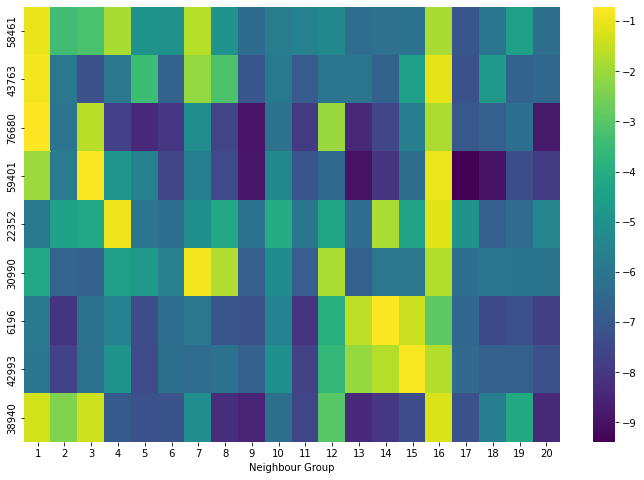

In [89]:
fig, ax = plt.subplots(figsize=(12,8))
sns.heatmap(sub, yticklabels=1, cmap='viridis', ax=ax)
ax.set_xlabel('Neighbour Group')
ax.set_ylabel('')

In [141]:
probabilities.head()

,1,2,3,4,5,6,7,8,9,10,...,13,14,15,16,17,18,19,20,best,NG
id,,,,,,,,,,,,,,,,,,,,,
58461,0.367853,0.033879,0.040404,0.156230,0.007147,0.007048,0.187067,0.007183,0.001662,0.003132,...,0.001812,0.002052,0.002285,0.157949,0.000859,0.002493,0.010651,0.001828,0.367853,1
43763,0.421742,0.002736,0.000737,0.002621,0.031982,0.001298,0.118963,0.042308,0.000842,0.002772,...,0.002420,0.001296,0.011023,0.343480,0.000726,0.008916,0.001226,0.001470,0.421742,1
76680,0.487843,0.002426,0.197683,0.000433,0.000231,0.000330,0.005763,0.000494,0.000131,0.002108,...,0.000225,0.000510,0.003411,0.166545,0.000896,0.001131,0.001870,0.000152,0.487843,1
23582,0.880194,0.000067,0.000072,0.000045,0.000858,0.000058,0.000916,0.000153,0.000029,0.000173,...,0.000021,0.000016,0.000060,0.115987,0.000050,0.000133,0.000607,0.000093,0.880194,1
14644,0.881935,0.000200,0.000334,0.000042,0.000390,0.000070,0.000554,0.000099,0.000025,0.000099,...,0.000018,0.000036,0.000034,0.115535,0.000018,0.000015,0.000105,0.000058,0.881935,1


In [135]:
probabilities_1  = probabilities[probabilities["NG"] == 1]

In [136]:
probabilities_1.mean()

1       0.993911
2       0.000202
3       0.000980
4       0.000321
5       0.000098
6       0.000025
7       0.000821
8       0.000109
9       0.000008
10      0.000033
11      0.000024
12      0.000430
13      0.000011
14      0.000011
15      0.000040
16      0.002876
17      0.000008
18      0.000030
19      0.000050
20      0.000012
best    0.993911
NG      1.000000
dtype: float64

In [160]:
probabilities_Grouped_NG = probabilities.groupby('NG')['best'].agg(['mean', 'size', 'median'])

In [161]:
probabilities_Grouped_NG.to_excel('../../Data/probabilities_Grouped_NG.xlsx')

In [216]:
coremlst = [x for x in df_combined.columns if str(x).startswith('CAMP')]

In [213]:
def modeFreq(x):
    coremlst_mode = x.mode().values[0]
    prop = (coremlst_mode == x).sum() / len(x)
    return prop

In [249]:
probabilities_Grouped_NG

,mean,size,median
NG,,,
1,0.993911,537,0.999615
2,0.997526,378,0.999904
3,0.995973,396,0.999347
4,0.997542,1105,0.999962
5,0.903869,8,0.966324
6,0.613010,1,0.613010
7,0.958927,46,0.985532
8,0.998731,1862,0.999905
10,0.999793,909,0.999969


In [229]:
Modefrequency_NGroups = df_combined.groupby('NG')[coremlst].apply(modeFreq)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'int' and 'str'
  warn(f"Unable to sort modes: {err}")
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'float' and 'str'
  warn(f"Unable to sort modes: {err}")


In [256]:
Modefrequency_NGroups_count = (Modefrequency_NGroups == 1).sum(axis=1)

In [257]:
Modefrequency_NGroups_count

NG
1        2
2       29
3       25
4        0
5      348
6     1311
7       39
8        2
10      93
12       3
13     111
14     230
15       3
16       0
17     116
18       0
19    1323
dtype: int64

In [250]:
probabilities_Grouped_NG

,mean,size,median
NG,,,
1,0.993911,537,0.999615
2,0.997526,378,0.999904
3,0.995973,396,0.999347
4,0.997542,1105,0.999962
5,0.903869,8,0.966324
6,0.613010,1,0.613010
7,0.958927,46,0.985532
8,0.998731,1862,0.999905
10,0.999793,909,0.999969


In [246]:
Modefrequency_NGroups.shape

(17, 1343)

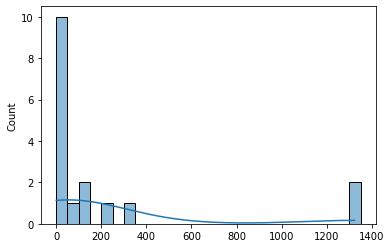

In [258]:
sns.histplot(Modefrequency_NGroups_count,binwidth=50,kde=True)